3章では分類について学びます。

In [135]:
%matplotlib inline
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "/Users/tm/Documents/python/ML_seminar/handson-ml_tm"
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MINIST

NMIST dataset を使用します。このデータセットは、70,000 の手書きの数字のイメージです。<br>それぞれの画像には、その画像が表す数字がラベル付けされています。<br>（このデータセットは、数字の分類の機械学習をするときのテストセットとしてよく使われるものです。）



MINIST dataset を Scikit-Learn にてダウンロードする。

In [136]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [137]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

Scikit-Learn でロードしたデータセットは、Dictionary structure に似たデータ構造を持つ。<BR><BR>
DESCR: データセットを記述 <BR>
data: array 構造で、インスタンスごとに1行、feature 毎に1カラムを含む<BR>
target: ラベルを持つ array<BR>

実際のデータを見てましょう！

In [138]:
X, y = mnist["data"], mnist["target"]

In [139]:
X.shape

(70000, 784)

In [140]:
y.shape

(70000,)

70,000 inages と 784 features をもつ。<BR>
これは、それぞれの image が 28x28 (784) ピクセルを持つからである。そして、それぞれの feature はひとつのピクセルの明暗度を示す。(from 0 (白) to 255 (黒))<BR><BR>
データセットから一つの数字でピークをとる。やることは、インスタンスの feature vector をとり、28x28 のarrayに変換、そして、Matplotlib's imhsow() 関数を使って表示する。

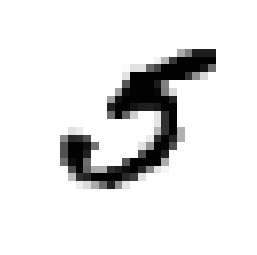

In [141]:
# テキストのコード #
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]   # 36000 番目のイメージを選択
some_digit_image = some_digit.reshape(28, 28)

#interpolation= 'nearest'は、表示解像度が画像解像度（ほとんどの場合にそうである）と同じでない場合、
#ピクセル間を補間することなく画像を単に表示するだけです。これは、画像画素が複数の表示画素の正方形として表示される画像をもたらす。

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest") 
plt.axis("off")
plt.show()

Saving figure some_digit_plot


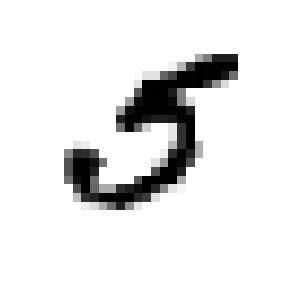

In [142]:
# サンプルのコード だと関数化され、さらに画像をsaveするようになっていた。#
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_digit_index = 36000
some_digit = X[some_digit_index]
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()

これは 5 にみえる。

target に格納されているラベルを見てみると、

In [143]:
y[36000]

5.0

5とラベルされていました。

テキストの 「Figure 3.1 MINIST データセットからのいくつかの数字」
サンプルコードでは描画している。

0
Saving figure more_digits_plot


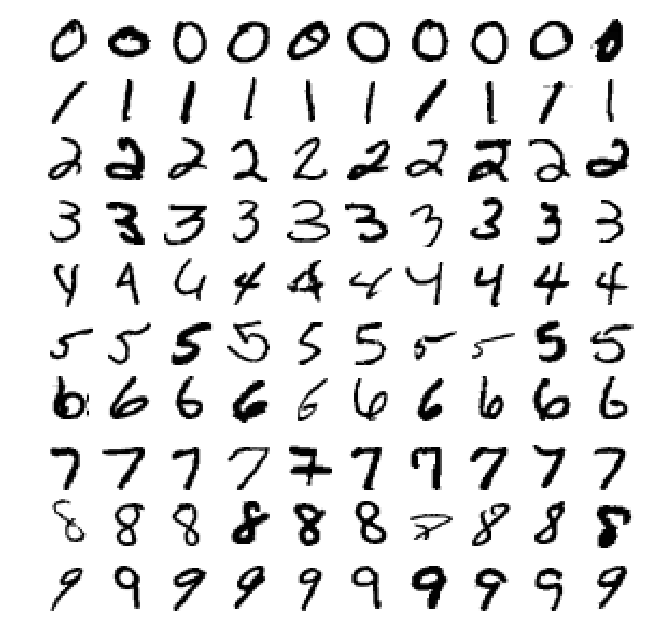

In [144]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    # 画像の数と、1行にイメージを何個表示させるかの設定とで、小さい方の値をimage_per_rowに入れる。
    images_per_row = min(len(instances), images_per_row)

    # 画像ピクセルデータをreshapeして、28行28列の行列にする。
    images = [instance.reshape(size,size) for instance in instances]
    
    # 割り算は「/」と「//」がある。
    #「//」演算子では浮動小数点数の場合であっても演算結果は小数点以下は切り捨てられます。
    n_rows = (len(instances) - 1) // images_per_row + 1
    # 10 = 99 // 10 + 1
    
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    # 10 * 10 - 100
    print (n_empty)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
# Xに入っている画像データを抽出しnp.r_ で行列を連結させている。
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]] 
# 1行にイメージを10個の画像を作成
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

トレーニングセットとテストセットの作成

MNISTデータセットは、既にトレーニングセット (最初の60,000イメージ) と テストセット(後ろの10,000イメージ) に分割されている。

In [145]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [146]:
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([ 0.,  0.,  0., ...,  9.,  9.,  9.]))

トレーニングセットをシャッフルする。これは、すべてのcross validation のために分割された標本群が似ることを保証する。さらに、いくつかの学習アルゴリズムは、トレーニングインスタンスの順番に敏感であり、そして、たくさんの似たインスタンスが行に存在すると結果が悪くなる。

In [147]:
shuffle_index = rnd.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [148]:
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([ 1.,  6.,  6., ...,  0.,  2.,  9.]))

# Training a binary classifier

問題をシンプルにするために、ここでは、一つの数字だけを同定する。<br>
例として、5 or not-5 を判定する。

ターゲット vectors を作成する。

In [149]:
y_train_5 = (y_train == 5)  #値が5 or not5 で True or False のvector がつくられる。
y_test_5 = (y_test == 5)

In [150]:
y_train_5, y_test_5

(array([False, False, False, ..., False, False, False], dtype=bool),
 array([False, False, False, ..., False, False, False], dtype=bool))

分類器を選び、学習させる。<br>
分類器: <i>Stochastic Gradient Descent</i> classifier <br> 
Scikit-learn のクラス: SGDClassifier <br>
この分類器は、とても大きなデータセットでも、効率的に分類することができる。これは、SGDがトレーニングインスタンスを個別に1つずつ処理するため。（SGDはオンライン学習にも適している）詳細は後ほど。

In [151]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #結果の再現性を保持するため random_state を指定する。
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [152]:
help (SGDClassifier)

Help on class SGDClassifier in module sklearn.linear_model.stochastic_gradient:

class SGDClassifier(BaseSGDClassifier, sklearn.feature_selection.from_model._LearntSelectorMixin)
 |  Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
 |  
 |  This estimator implements regularized linear models with stochastic
 |  gradient descent (SGD) learning: the gradient of the loss is estimated
 |  each sample at a time and the model is updated along the way with a
 |  decreasing strength schedule (aka learning rate). SGD allows minibatch
 |  (online/out-of-core) learning, see the partial_fit method.
 |  For best results using the default learning rate schedule, the data should
 |  have zero mean and unit variance.
 |  
 |  This implementation works with data represented as dense or sparse arrays
 |  of floating point values for the features. The model it fits can be
 |  controlled with the loss parameter; by default, it fits a linear support
 |  vector machine (SVM).
 |  
 |  

最初の方で使った 変数: some_digit (5のピクセル情報が格納されている) を使って分類器をテストしてみる。
#some_digit = X[36000]   # 36000 番目のイメージを選択

In [153]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

分類器は、5 (True) と分類した。

# Performance measures

分類器の評価は、回帰の評価よりかなり扱いにくい。

### cross validation を使った精度検証

cross_val_score() 関数で、3層の K-fold cross-validation を使った SGDClassifier モデル の精度検証を行う。

In [154]:
from sklearn.model_selection import cross_val_score
help (cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like
        The data to fit. Can be, for example a list, or an array at least 2d.
    
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.
    
    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer 

In [155]:
#scoring に設定できる callable な関数はこちらを参照 http://scikit-learn.org/stable/modules/model_evaluation.html
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

95％の精度が出た！<br>
興奮する前に、全てのイメージに対して "not-5" を予測する分類器を作成して精度を見てみる。<br>
これは "5" の画像を渡しても、"not-5" と返す。

In [156]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # np.zeros を dbtype=bool で実行すると全てがfalse の結果を返す。

In [157]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

精度が 約90％くらいになった。これは、画像全体 (0-9の数字)の中の 10％くらいが 5の画像なので、全ての画像に対して "not-5" を返すと、10％くらいの割合で予測が間違えていることになる。

これは、なぜ、accuracy が一般的に分類器のperformance measure として好まれないかを示した例です。<br>
とくに、skewed datasets (例えば、幾つかのクラスが、他のクラスより、頻出だったり...)を扱うときには。<BR><br>

精度として出た値が、素晴らしいのか、そうでないのか、判断がつき難いって意味でいいですか？？？<br>

Implementing cross-validation の赤いボックス内について

cross_val_score() や、それに類似した関数を使うより、より、cross-validation 処理をコントロールする必要がある場合、cross-validationを自分で実装することができる。以下のコードは、だいたい cross_val_score() と同じコードで、同じ結果が出力される。

In [158]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42) # データを3分割にする。

for train_index, test_index in skfolds.split(X_train, y_train_5):  # 3回のcross-validation 分処理を続ける。
    clone_clf = clone(sgd_clf)　　　　　　　　　　　　# 上記で作成した分類器のクローンを作成する。
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

SyntaxError: invalid character in identifier (<ipython-input-158-4456eb2b0027>, line 7)

In [159]:
help(clone)

Help on function clone in module sklearn.base:

clone(estimator, safe=True)
    Constructs a new estimator with the same parameters.
    
    Clone does a deep copy of the model in an estimator
    without actually copying attached data. It yields a new estimator
    with the same parameters that has not been fit on any data.
    
    Parameters
    ----------
    estimator: estimator object, or list, tuple or set of objects
        The estimator or group of estimators to be cloned
    
    safe: boolean, optional
        If safe is false, clone will fall back to a deepcopy on objects
        that are not estimators.



StratifiedKFold class は、各々のclass の代表的な比率を含む folds を生成するために、stratified sampling (層化抽出法) を実装する。各々の繰り返しで、コードは、分類器のクローンを作成し、トレーニング fold をクローン上でトレーニングし、テスト fold で予測を行う。それから、正解した予測の数をカウントし、正解率を出力する。

### Confusion matrix (混同行列)

分類器のperformance検証でよりよい方法は、confusion matrix である。(http://popo.ara.black/etc/confusionmatrix.htm)<br>
基本的な考え方としては、class A のインスタンスが class Bとして分類された回数を数える。<BR>
例えば、分類器が イメージ 5 を 3と間違えた回数を知るために、あなたは、confusion matrix の5行目、3カラム目にいます？<br>
<br>
confision matrix を計算するために、予測結果のセットを持つ必要があり、そして、それと実際の値とを比較する。テストセットの結果を作ることはできるけど、ここではそれを使わずに cross_val_predict() を使う。

In [160]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [161]:
y_train_pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [162]:
len(X_train)  #60000件のデータを1/3ずつテストデータに回してcross validation して
              #その結果を y_train_predに入れているので、y_train_pred も60000件のデータになっている。

60000

In [163]:
len(y_train_pred)

60000

cross_val_score() に似ていて、cross_val_predict()も k-fold cross-validationを実装し、evaluation scoresの代わりに、それぞれのテスト foldの作成した予測を返す。これは、トレーニングセットのそれぞれのインスタンスから clean prediction を得たことを意味する。このclean とは トレーニング中の出会ったことのないデータによるモデルによって、予測されているって意味。

正解セットの結果 y_train と 予測した結果の y_train_pred から、 confusion_matrix() を使って confusion matrix を作成する。

In [164]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

                            実際のクラス
                            Negative           Positive           
予測されたクラス  Negative    True Negative      False Positive         
               Positive    False Negative     True Positive


1行目: non-5 イメージ
53272 : non-5　と正しく分類された数 (True Negative)
1307  : 5 であると間違えて分類された数 (False Positive)

2行目: 5 イメージ
1077  : non-5 と間違えて分類された数 (Flase Negative)
4344  : 5 であると正しく分類された数 (True Positive)

もし、予測した結果が全て正解なら、True Negative, Trye Positive のフィールド以外は、０になる。

In [165]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

confusion matrix は、あなたにたくさんの情報を与えるが、時には、より簡潔な 測定基準 (metric) を好むこともあるだろう。<br>
positive prediction の精度 (5と予測されたもののうち、正解であった割合)<br>
Precision = TP / (TP + FP)
<br><br>

完全な精度を持つための些細な方法は、1つの単一の正の予測を行い、正しいことを確認することです (precision = 1/1 = 100％)。これは、分類器が1つのPositiveなインスタンス以外のすべてを無視するため、あまり有用ではありません。？何がいいたいのかがよく分からない。？ <BR>
だから、Precision は、recall, sensitivity or True Positive Rate (TPR) などと呼ばれる他の metric が使われる。
recall, sensitivity or TPR と呼ばれる metric は、分類器によって正確に検出された positive instance の比率です。<br>
 (5のイメージのうち、正しく5と分類された割合) <br>
recall = TP / (TP + FN)<br><br>


### Precision and recall (適合率と再現率)

Scikit-Learn は classifier matrics (precision と recall を含む) を計算するためのいくつかの関数を提供する。

In [166]:
from sklearn.metrics import precision_score, recall_score

In [167]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  #4344 / (4344 + 1307)

0.76871350203503808

In [168]:
recall_score(y_train_5, y_train_pred)  #4344 / (4344 + 1077)

0.80132816823464303

5-detector は、その accuracy を見たときと同じように輝いて見えません。5-detector が 5だと主張したときに、それが正解するのは、たった77％です。 さらに、それは 実際に5の画像のうち、79％しか検出できない。 <br><br>

特に、もしあなたが、２つの分類気を比較するシンプルな方法が必要な場合には、precision と recall をひとつのmetric に結合した F<sub><small>1</small></sub> score　が便利です。 F<sub><small>1</small></sub> score は、precision と recall の<i>harmonic mean (調和平均)</i> です。一方、regular mean はすべての値を均等に扱うが、harmonic mean (調和平均) は、低い値に対してより重みを与える。分類器は、もし、recall and precision の両方が高ければ、F<sub><small>1</small></sub> score は、高い値が得られる。

F<sub><small>1</small></sub> score を計算する。

In [169]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78468208092485547

F<sub><small>1</small></sub> score は、precision と recall がにている分類器では好まる。これは必ずしもあなたが望むものではない。状況によっては、precision について care するが、他のケースでは recall をcareする。
<br><br>
たとえば、子供にとって安全な動画を検出するために分類器をトレーニングする場合、あなたは、おそらく「良い動画をたくさん採用する (high recall) が いくつかのすごく悪い動画をも採用する(low precision) 」分類器よりむしろ、「多くの良い動画をrejectする（low recall）が、安全なものだけを保持する（high precision）」分類器を好むだろう。（このようなケースは、あなたはまさに human pipelineを動画選択分類器をチェックするために追加したいだろう。）一方、監視画像で盗人を検出するために分類器を訓練したとします。もし、99％の recall があれば分類器のprecisionは30%でもよいだろう。（確かに、警備員は誤警報をいくつか得るが、ほとんどすべての万引きが捕まってしまう）
<br><br>
残念なことに、あなたはそれを両方の方法で持つことはできない。精度を上げるとリコールが減少し、逆も同様。これは precision / recall tradeoff  と呼ばれる。

## precision / recall tradeoff 

Tradeoff を理解するために、SGDClassifier がどのように分類を決定するのかを見てみましょう。

各インスタンスに対して、decision function に基づいてスコアが計算され、もし、そのスコアが閾値よりも大きければ、そのインスタンスは positive class にアサインされ、そうでなければ、negative class にアサインされる。

Figure 3-3 は、左から右へスコアが小さいものから大きいものへと、数字の画像が並んでいる。


decision threshold が中央の矢印（2つの5つの間）に位置していると仮定する: threshold の右側に4つの true positive があり、1つの false positive (実際は6)がある。それゆえに、precision 80%。しかし、6つの実際の5のうち、分類器は4つしか検出しないので、recallは67％（6のうち4つ）です。

もし、threshold を上げたいなら (矢印の右側に移動する)、false positive の6 は true negative になる。それによって精度が向上します（この場合、最大100％）。しかし、true positive が false negative になり、recall は 50%に減少する。逆に、Treshold を下げると recall が増え、精度が低下します。

Scikit-Learn は、直接 threshold をユーザにセットさせないが、予測を行うために使用する decision score にアクセスできる: 分類器の predict() メソッドを呼ぶ代わりに、各々のインスタンスのスコアを返す decision_function() メソッドを呼ぶことができ、そして、あなたが望むいくつかの threshold を使用して、これらのスコアに基づいた予測をすることができる。

In [170]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

In [171]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

SGDClassifier　は threshold = 0 を使う、だから、上のコードは predict() と同じ結果を返す (ie. True)。

threshold を上げてみましょう:

In [172]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

これは、thresholdを上げるとrecallが減少することを確認する: イメージは実際には5を表し、分類器は threshold が0のときにそれを検出するが、threshold が200000に増加したときに分類器はそれを検出しない。
どのようにして threshold を決めるか？ このためには、cross_val_predict（）関数を再度使用してトレーニングセット内のすべてのインスタンスのスコアを取得する必要があるが、今回は予測ではなく decision score を返すように指定する。

In [173]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

これらのスコアを使用して、precision を計算し、precision_recall_curve（）関数を使用して考えられるすべての threshold を呼び出すことができる。

In [174]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


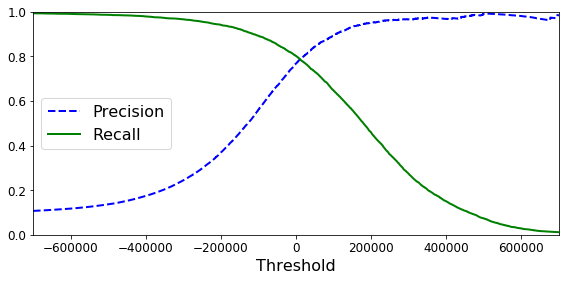

In [176]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

なぜ precision が recall よりも揺らいでいるのか疑問に思うかもしれない。 これは、threshold を上げると precision が低下することがあるためである（通常は上がりが）。 理由を理解するには、図3-3に戻り、中央の threshold から始めて1つ数字イメージを右に移動すると、precision は4/5（80％）から3/4（75 ％）になる。 一方、recall は、threshold が増加したときにのみ下降することができるので、カーブが滑らかに見える。

これで、タスクの precision/recall tradeoff を最適化するための threshold を簡単に選択できる。 よい precision/recall tradeoffを選択するもう1つの方法は、図3-5に示すように、recall に対して precision を直接プロットすることである。

precision は、実際には約80％のrecallで急激に低下し始めていることがわかる。 たとえば、約60％のrecallで、そのドロップの直前にprecision/recallのtradeoffを選択したいとする。 もちろん、その選択はプロジェクトによって異なる。
だから、あなたは90％の精度を目指すことを決めたとする。 最初のプロット（少し拡大表示）を調べると、約70,000のthresholdを使用する必要があることがわかる。 今のところトレーニングセットで予測を行うには、分類器のpredict（）メソッドを呼び出すのではなく、次のコードを実行するだけです。

In [178]:
y_train_pred_90 = (y_scores > 70000)

Let’s check these predictions’ precision and recall:

In [179]:
precision_score(y_train_5, y_train_pred_90)

0.86592051164915484

In [180]:
recall_score(y_train_5, y_train_pred_90)

0.69931746910164172